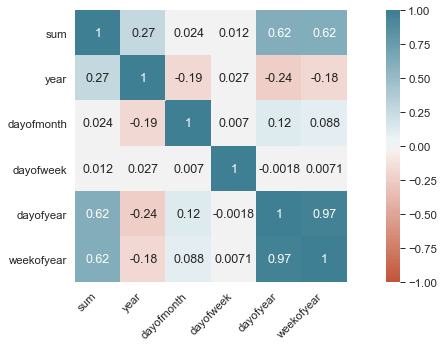

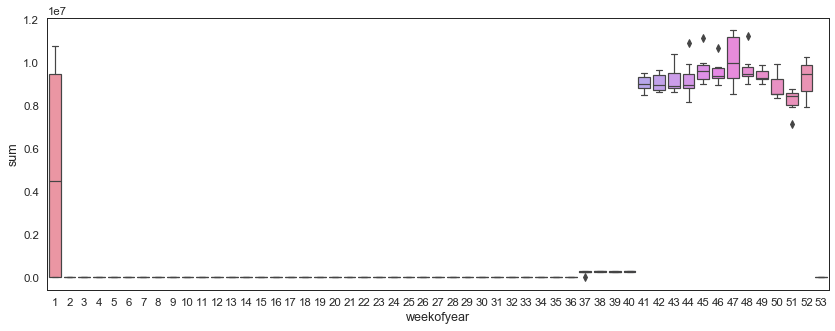

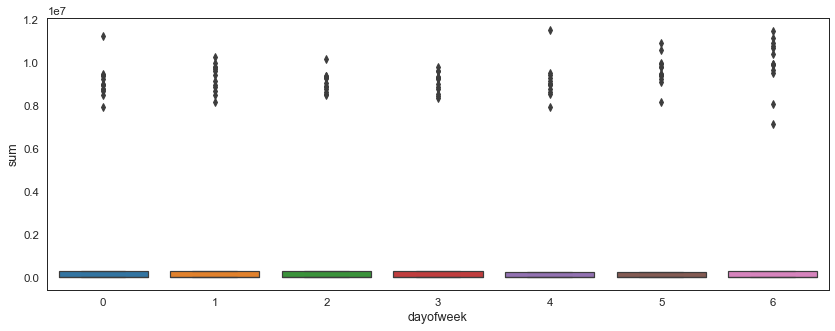

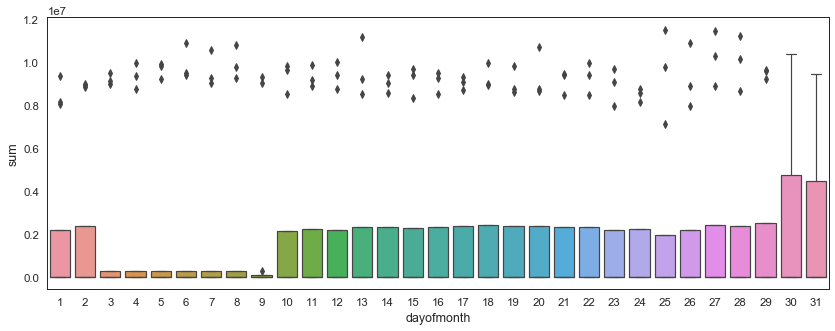

Fitting 5 folds for each of 1350 candidates, totalling 6750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 710 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 2052 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 3852 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 6052 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 6750 out of 6750 | elapsed:   12.2s finished


***********************************************
model classes  [0 1]
***********************************************
Prediction probabilities for 2 classes
***********************************************
[[0.02721363 0.97278637]
 [0.02721363 0.97278637]
 [0.02721363 0.97278637]
 [0.02721363 0.97278637]
 [0.02721363 0.97278637]
 [0.02721363 0.97278637]
 [0.02721363 0.97278637]
 [0.02721363 0.97278637]
 [0.02721363 0.97278637]
 [0.02721363 0.97278637]
 [0.02721363 0.97278637]
 [0.02721363 0.97278637]
 [0.02721363 0.97278637]
 [0.04199684 0.95800316]
 [0.04199684 0.95800316]
 [0.04199684 0.95800316]
 [0.04199684 0.95800316]
 [0.97894454 0.02105546]
 [0.97894454 0.02105546]
 [0.97894454 0.02105546]
 [0.97894454 0.02105546]
 [0.97894454 0.02105546]
 [0.97894454 0.02105546]
 [0.97894454 0.02105546]
 [0.97894454 0.02105546]
 [0.97894454 0.02105546]
 [0.97894454 0.02105546]
 [0.97894454 0.02105546]
 [0.97894454 0.02105546]
 [0.9760164  0.0239836 ]
 [0.9760164  0.0239836 ]
 [0.9760164  0.023983

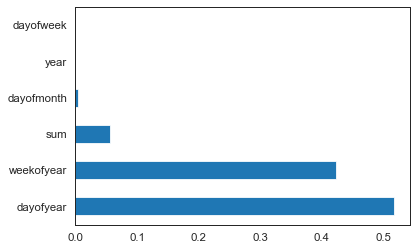

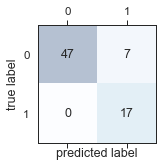

In [31]:
#%%
# This script implements XGBoost timeseries classifier for challenge data
# Idea is to build a classifier for Outlier.
# It's an open ended problem in terms of what classifier we are trying to build.
# Data exploration provided the data landscape about noisy vs non-noisy data 

__author__ = "Minakshi Mukherjee"


import seaborn as sns
import numpy as np 
import pandas as pd 
import pymysql
import matplotlib.pyplot as plt
import time
import warnings
import Access_module
import importlib
from datetime import datetime, date, timedelta
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, precision_recall_curve, auc,roc_auc_score
from matplotlib import pyplot as plt, style
from tabulate import tabulate
from time import gmtime, strftime
from statsmodels.tsa.stattools import adfuller
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
warnings.filterwarnings("ignore")


# It sets up the maximum display if output is viwed in notebook
def setup():
    pd.set_option('display.max_rows', 3000)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.float_format', lambda x: '%.4f' % x)
    sns.set_context("paper", font_scale=1.3)
    sns.set_style('white')
    
# Function for splitting train,test based on different dates
def train_test_split(df, date_col, start_date,end_date,split_date):
    X = df[['sum','year','dayofmonth','dayofweek','dayofyear','weekofyear']]
    df_train = df[(df[date_col] <= end_date) | ((df[date_col] >= start_date) & (df[date_col] <= split_date))]
    df_test = df[((df[date_col] > end_date) & (df[date_col] < start_date)) | (df[date_col] > split_date)]
    
    X_train = df_train[['sum','year','dayofmonth','dayofweek','dayofyear','weekofyear']]
    Y_train = df_train['encoded_label']
    X_test = df_test[['sum','year','dayofmonth','dayofweek','dayofyear','weekofyear']]
    Y_test = df_test['encoded_label']
    
    return X, X_train, Y_train, X_test, Y_test

# Function for Grid serach pipeline for XGBoost
def algorithm_pipeline(X_train, X_test, Y_train, Y_test, 
                   model, param_grid):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        n_jobs=-1, 
        verbose=True
    )
    fitted_model = gs.fit(X_train, Y_train.values.ravel())
    train_pred = fitted_model.predict(X_train)

    pred_proba = fitted_model.predict_proba(X_test)
    test_pred = fitted_model.predict(X_test)
    
    feat_importances = pd.Series(fitted_model.best_estimator_.feature_importances_, index=X_train.columns)
    feat_importances.nlargest(12).plot(kind='barh')

    return fitted_model, train_pred, test_pred, pred_proba

# Function for Grid serach pipeline for XGBoost
def more_data_insights(X):
    plt.figure(figsize=(14,5))
    corr = X.corr()
    ax = sns.heatmap(
    corr, annot=True,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
    ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
    plt.show()
    plt.figure(figsize=(14,5))
    sns.boxplot(X['weekofyear'], X['sum'])
    plt.show()
    plt.figure(figsize=(14,5))
    sns.boxplot(X['dayofweek'], X['sum'])
    plt.show()
    plt.figure(figsize=(14,5))
    sns.boxplot(X['dayofmonth'], X['sum'])
    plt.show()
    
# Accuracy metrics 
def model_accuracy(fitted_model):
    print(fitted_model.best_params_)
    train_accuracy = balanced_accuracy_score(Y_train, train_pred)
    y_pred = model.predict(X_test)
    test_accuracy = balanced_accuracy_score(Y_test, test_pred)
    print("***********************************************")
    print("Balanced Accuracy for Train: %.2f%%" % (train_accuracy * 100.0))
    print("***********************************************")
    print("Balanced Accuracy for Test: %.2f%%" % (test_accuracy * 100.0))  
    
# F score and Confusion matrix 
def f_score_conf_matrix(Y_test, y_pred):
    print('f1_score: %.3f' % f1_score(Y_test, y_pred))
    print("***********************************************")
    confmat=confusion_matrix(Y_test,y_pred)
    print(" Confusion Matrix: ")
    print("***********************************************")
    print(confmat)
    
    fig, ax = plt.subplots(figsize=(2.5, 2.5))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i,s=confmat[i, j],va='center', ha='center')
    plt.xlabel('predicted label')
    plt.ylabel('true label')
    plt.tight_layout()
    

def model_predict_new_data(fitted_model,pred_df):
    final_predict = model.predict_proba(df3)
    print("Shape of predict: ",final_predict.shape)
    
    
# main     
if __name__ == "__main__":
    start = time.time()
    
    setup()
    ######################## READ MODEL INPUT/ SPLIT TRAIN-TEST ##################################
    start_date ='2016-04-01'
    end_date = '2016-03-14'
    split_date = '2016-11-15'
    model_input_df=pd.read_pickle('ml_input_df_final.pickle')

    X, X_train, Y_train, X_test, Y_test = train_test_split(model_input_df, 'date', start_date,end_date,split_date)
    
    ######################## MORE DATA INSIGHTS       ##################################
    more_data_insights(X)

    ######################## FIT XGBoost Classifier ##################################
    model = XGBClassifier()
    param_grid = {
        'n_estimators': [300, 400, 500],
        'max_depth': [2,4,6],
        'reg_alpha': [0],
        'reg_lambda': [1],
        'random_state': [0],
        'min_child_weight': [4, 5],
        'gamma': [i / 10.0 for i in range(3, 6)],
        'learning_rate': [0.1],
        'colsample_bytree': [i / 10.0 for i in range(6, 11)],
        'colsample_bylevel': [i / 10.0 for i in range(6, 11)],
        'rate_drop': [.1],
        'objective': ['binary:logistic']
    }
    
    ######################## PARALLEL PROCESSING ##################################    
    n_cores = 32
    max_threads = n_cores*2
    
    ######################## BUILD MODEL ##################################
    model, train_pred, test_pred, pred_proba = algorithm_pipeline(X_train, X_test, Y_train, Y_test, model, param_grid)
    
    ######################## REPORT ON METRICS ##################################
    print("***********************************************")
    print("model classes ",model.classes_)
    print("***********************************************")
    print("Prediction probabilities for 2 classes")
    print("***********************************************")
    print(pred_proba)
    print("Best model parameters")
    print("***********************************************")
    model_accuracy(model)
    f_score_conf_matrix(Y_test, test_pred)      
    
    end = time.time()
    print(strftime("%a, %d %b %Y %H:%M:%S +0000", gmtime()))
    print("Total time taken(in seconds)-> ", end-start)

In [32]:
predict_df = pd.read_pickle('predict_df.pickle')
new_pred = model.predict(predict_df)
new_prob = model.predict_proba(predict_df)
print("new_pred", new_pred)
print("new_prob", new_prob)

new_pred [1 1 1 1]
new_prob [[0.02721363 0.97278637]
 [0.02721363 0.97278637]
 [0.08073413 0.91926587]
 [0.02721363 0.97278637]]
